In [1]:
import sys
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from torch_geometric.data import Dataset, download_url, Data
import pandas as pd
import shutil
import torch
from scipy.spatial import distance

from torch_geometric import nn as gnn
import torch.nn.functional as F
from torchvision.transforms.functional import crop
from torch import nn



from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from torch.nn import Sequential as Seq

from tqdm import tqdm

sys.path.append('/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation')
from onegraph_rest_free_graphds import OneGraphDS
from gan_based_models import Discriminator
from second_stage_vig_based_models import FullModel
from vig_based_functions import act_layer, get_multi_shot_set
from vig_graph_modules import GrapherSetEdges, FFN
from perceptual_loss import VGGPerceptualLoss

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing f

In [2]:
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_202_with_tiles_processed.pk1', 'rb') as handle:
    data = pickle.load(handle)

In [3]:
data.keys()

dict_keys(['name', 'image', 'features', 'factor', 'cluster', 'centroids', 'umap_reducer', 'tiles', 'tile_features', 'tile_cluster', 'tile_centroids', 'tile_images', 'tile_factor', 'all_tiles', 'tile_knn_edge_index'])

In [16]:
SAVE_PATH = "whatmatters_split_eye_tile_dataset.pickle"
with open(SAVE_PATH, 'rb') as handle:
    data = pickle.load(handle)

train_tiles = data["train_tiles"]
test_tiles = data["test_tiles"]
train_cluster = data["train_cluster"]
test_cluster = data["test_cluster"]
cluster_dists = data["train_cluster_dists"]
te_cluster_dists = data["test_cluster_dists"]

print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)
print(cluster_dists.shape)
print(te_cluster_dists.shape)

torch.Size([775, 56, 56, 3])
torch.Size([264, 56, 56, 3])
torch.Size([775])
torch.Size([264])
torch.Size([775, 12])
torch.Size([264, 12])


# Data

In [4]:
#from sklearn.cluster import KMeans
#B,H,W,C = train_tiles.shape
#B2,H,W,C = test_tiles.shape
train_tiles = torch.Tensor(data["image"])
#x = train_tiles.reshape(B,-1)
train_tiles.shape

torch.Size([202, 224, 224, 3])

In [8]:
from sklearn.cluster import KMeans
x = train_tiles.reshape(train_tiles.shape[0], -1)
kmeans = KMeans(n_clusters=5)
kmeans.fit(x)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [9]:
train_tiles_clusters = torch.Tensor(kmeans.labels_).to(torch.int)

In [10]:
unique, counts = np.unique(train_tiles_clusters, return_counts=True)

print(counts)
print(train_tiles.shape)
print(train_tiles_clusters.shape)

[38 42 54 42 26]
torch.Size([202, 224, 224, 3])
torch.Size([202])


In [ ]:
centroids = torch.Tensor(kmeans.cluster_centers_).reshape(12,56,56,3)

In [54]:
train_counts=np.array(np.floor(counts*0.75), dtype=np.int64)
print(train_counts)
print(train_counts.sum())
print(counts - train_counts)
print((counts - train_counts).sum())
print((train_counts+(counts-train_counts)) == counts)

[ 61  38  30  53  40  51  50 174  42  49  83 104]
775
[21 13 11 18 14 17 17 59 14 17 28 35]
264
[ True  True  True  True  True  True  True  True  True  True  True  True]


In [55]:
rng = np.random.default_rng()
test_ind = []
train_ind = []
unique, counts = np.unique(train_tiles_clusters, return_counts=True)

for cluster, count in zip(np.unique(train_tiles_clusters), train_counts):
    main_array = np.where(train_tiles_clusters == cluster)[0]
    train_values = rng.choice(main_array, size=count, replace=False)
    test_values = np.setdiff1d(main_array, train_values)
    
    train_ind.extend(train_values)
    test_ind.extend(test_values)

train_ind = np.array(train_ind)
test_ind = np.array(test_ind)
    

In [56]:
print(train_ind.shape)
print(test_ind.shape)

(775,)
(264,)


In [57]:
test_tiles = train_tiles[test_ind]
train_tiles = train_tiles[train_ind]

train_cluster = train_tiles_clusters[train_ind]
test_cluster = train_tiles_clusters[test_ind]

print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)

torch.Size([775, 56, 56, 3])
torch.Size([264, 56, 56, 3])
torch.Size([775])
torch.Size([264])


In [155]:
#n+=1
#print(n)
#print("Cluster:",train_cluster[n].item())
cluster_dists = []
with torch.no_grad():
    for tiles in train_tiles:
        aux = []
        for centroid in centroids:
            aux.append(torch.dist(tiles, centroid, p=2))
        aux = torch.Tensor(aux)
        cluster_dists.append(aux)
    cluster_dists = torch.stack(cluster_dists)

cluster_dists = (cluster_dists - torch.min(cluster_dists))/(torch.max(cluster_dists) - torch.min(cluster_dists))

In [156]:
#n+=1
#print(n)
#print("Cluster:",train_cluster[n].item())
te_cluster_dists = []
with torch.no_grad():
    for tiles in test_tiles:
        aux = []
        for centroid in centroids:
            aux.append(torch.dist(tiles, centroid, p=2))
        aux = torch.Tensor(aux)
        te_cluster_dists.append(aux)
    te_cluster_dists = torch.stack(te_cluster_dists)

te_cluster_dists = (te_cluster_dists - torch.min(te_cluster_dists))/(torch.max(te_cluster_dists) - torch.min(te_cluster_dists))

In [157]:
cluster_dists.shape

torch.Size([775, 12])

In [600]:
print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)
print(cluster_dists.shape)
print(te_cluster_dists.shape)

torch.Size([775, 56, 56, 3])
torch.Size([264, 56, 56, 3])
torch.Size([775])
torch.Size([264])
torch.Size([775, 12])
torch.Size([264, 12])


In [ ]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_split_eye_tile_dataset.pickle"
data = {"train_tiles":train_tiles, "test_tiles":test_tiles, "train_cluster":train_cluster, "test_cluster":test_cluster, "train_cluster_dists":cluster_dists, "test_cluster_dists":te_cluster_dists}
with open('whatmatters_split_eye_tile_dataset.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Models

In [6]:
class DiscDownBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
      super().__init__()
      self.convs = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, 3, stride=2, padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(True),
      )

    def forward(self, x):
      return self.convs(x)
    
class DiscStrideBlock(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.convs = nn.Sequential(
      nn.Conv2d(in_dim, in_dim, 3, stride=1, padding=1),
      nn.BatchNorm2d(in_dim),
      nn.ReLU(True),
    )

  def forward(self, x):
    return self.convs(x)

class DiscBlock(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()
    self.down = DiscDownBlock(in_dim, out_dim)
    self.stride = DiscStrideBlock(out_dim)

  def forward(self, x):
    x = self.down(x)
    return self.stride(x)
    
class Discriminator(nn.Module):
    def __init__(self, in_dim, out_dim, num_cats):
      super().__init__()
      self.block1 = DiscBlock(in_dim, out_dim//4)
      self.block2 = DiscBlock(out_dim//4, out_dim//2)
      self.block3 = DiscBlock(out_dim//2, out_dim)

      self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(out_dim*7*7, 8192),
        nn.BatchNorm1d(8192),
        nn.ReLU(True),
        nn.Linear(8192, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(True),
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(True),
        nn.Linear(4096, num_cats),
        nn.Sigmoid(),
      )

    def forward(self, x):
      x1 = self.block1(x)
      x2 = self.block2(x1)
      x3 = self.block3(x2)
      x = self.classifier(x3)
      return [x1,x2,x3], x

In [20]:
class DetectorBlock(nn.Module):
  def __init__(self, out_dim, img_size):
    super().__init__()
    self.linear = nn.Sequential(
      nn.Flatten(),
      nn.Linear(out_dim*(img_size//2)*(img_size//2), 8192),
      nn.BatchNorm1d(8192),
      nn.ReLU(True),
    )

  def forward(self, x):
    return self.linear(x)
    
class Detector(nn.Module):
    def __init__(self, in_dim, out_dim, num_cats ,num_patches = 3, stride = 14, img_size=56, device="cuda:7"):
      super().__init__()
      self.block1 = DetectorBlock(out_dim//4, img_size)
      self.block2 = DetectorBlock(out_dim//2, img_size//2)
      self.block3 = DetectorBlock(out_dim, img_size//4)
      
      self.regressor = nn.Sequential(
        nn.Linear(8192*3, 8192),
        nn.BatchNorm1d(8192),
        nn.ReLU(True),
        nn.Linear(8192, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(True),
        nn.Linear(4096, num_patches*2),
        #nn.Sigmoid()
      )
      self.classifier = Discriminator(in_dim, out_dim, num_cats)
      self.stride = stride
      self.device = device

    def forward(self, x, x_in):
      B,C,H,W = x[0].shape
      x1 = self.block1(x[0])
      x2 = self.block2(x[1])
      x3 = self.block3(x[2])
      
      x = torch.cat([x1,x2,x3], dim=1)
      
      x1 = self.regressor(x)
      x1 = (x1 - torch.min(x1))/(torch.max(x1) - torch.min(x1))
      
      base = torch.ones(B,56,56,3)
      #base = (base - torch.min(base))/(torch.max(base) - torch.min(base))
      i=-1
      for b,xx in zip(base,x1):
        i+=1
        for o in xx.reshape(-1,2):
          x_min = int(o[0] * 56)
          y_min = int(o[1] * 56)
          x_max = x_min+self.stride
          y_max = y_min+self.stride
          b[x_min:x_max, y_min:y_max] = x_in[i].reshape(56,56,3)[x_min:x_max, y_min:y_max]
      
      base = base.to(self.device)

      x2, x = self.classifier(base.reshape(B,3,56,56))
      return x1, base, x, x2

In [8]:
EPOCHS = 200
BATCH_SIZE = 100
DEVICE = "cuda:7" if torch.cuda.is_available() else "cpu"

In [9]:
LR = 0.00005
model = Discriminator(3, 128, 12)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss = nn.MSELoss()

In [10]:
PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_init_d_model1.pickle"
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [542]:
for epoch in range(EPOCHS):
    print("Epoch:",epoch)
    
    running_loss = 0.0
    
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)

    train_index = train_index.T[:700].reshape(-1,BATCH_SIZE)
    i=-1
    
    model.train()
    for tr_ind in train_index:
        i+=1
        torch.cuda.empty_cache()
        
        x = train_tiles[tr_ind]
        y = cluster_dists[tr_ind]
        
        x = x.reshape(-1,3,56,56)
        y = y.to(DEVICE)
        x = x.to(DEVICE)
        
        conv, pred = model(x)
        del x
        pl = loss(pred,y)
        del y
        
        optimizer.zero_grad()
        pl.backward()
        optimizer.step()
        
        running_loss += pl.item()
    
    
    model.eval()
    with torch.no_grad():
        
        x = test_tiles
        y = te_cluster_dists
        
        x = x.reshape(-1,3,56,56).to(DEVICE)
        y = y.to(torch.long).to(DEVICE)
        conv, pred = model(x)
        tl = loss(pred,y)
        del x
        del y
    
    
    print("Train Loss:", running_loss)
    print("Test Loss:", tl.item())
    print()
    del pl, tl
        
        

Epoch: 0


Train Loss: 0.09773704130202532
Test Loss: 0.22279034554958344

Epoch: 1
Train Loss: 0.11587470583617687
Test Loss: 0.18520136177539825

Epoch: 2
Train Loss: 0.06125547410920262
Test Loss: 0.1601082682609558

Epoch: 3
Train Loss: 0.030876642325893044
Test Loss: 0.1523774266242981

Epoch: 4
Train Loss: 0.017175075132399797
Test Loss: 0.1686883419752121

Epoch: 5
Train Loss: 0.011832939577288926
Test Loss: 0.20152780413627625

Epoch: 6
Train Loss: 0.007993872684892267
Test Loss: 0.22658026218414307

Epoch: 7
Train Loss: 0.007469496224075556
Test Loss: 0.24440152943134308

Epoch: 8
Train Loss: 0.004760098294354975
Test Loss: 0.24934493005275726

Epoch: 9
Train Loss: 0.004006414412287995
Test Loss: 0.25686317682266235

Epoch: 10
Train Loss: 0.003463669476332143
Test Loss: 0.25693047046661377

Epoch: 11
Train Loss: 0.0037787009205203503
Test Loss: 0.2524816691875458

Epoch: 12
Train Loss: 0.0026194366510026157
Test Loss: 0.2580968737602234

Epoch: 13
Train Loss: 0.003622300719143823
Test Lo

In [11]:
for p in model.parameters():
    p.requires_grad = False

In [21]:
o_model = Detector(3, 128, 12, 12, 14, 56, DEVICE)
o_model = o_model.to(DEVICE)

In [22]:
EPOCHS = 500
O_LR = 0.0001
o_optimizer = torch.optim.Adam(o_model.parameters(), lr = O_LR)

In [23]:
for epoch in range(EPOCHS):
    model.eval()
    print("Epoch:",epoch)
    
    running_loss = 0.0
    
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)

    train_index = train_index.T[:700].reshape(-1,BATCH_SIZE)
    i=-1
    
    o_model.train()
    for tr_ind in train_index:
        i+=1
        torch.cuda.empty_cache()
        
        x = train_tiles[tr_ind]
        
        x = x.reshape(-1,3,56,56)
        x = x.to(DEVICE)
        
        y = cluster_dists[tr_ind]
        y = y.to(DEVICE)
    
        x2, y2 = model(x)
        
        _, _, pred, ls = o_model(x2, x)
        del x, _
        pl = 2*loss(pred,y)
        pl += loss(pred,y2)
        
        for x,y in zip(ls, x2):
            pl += 0.15 * loss(x, y)
        del y, y2, pred, x2, ls
        
        o_optimizer.zero_grad()
        pl.backward()
        o_optimizer.step()
        
        running_loss += pl.item()
    
    
    o_model.eval()
    with torch.no_grad():
        
        x = test_tiles
        y = te_cluster_dists
        y=y.to(DEVICE)
        
        x = x.reshape(-1,3,56,56).to(DEVICE)
        x2, y2 = model(x)
        _, _, pred, ls = o_model(x2, x)
        del x
        tl = 2*loss(pred,y)
        tl += loss(pred,y2)
        
        for x,y in zip(ls, x2):
            tl += 0.15 * loss(x, y)
            
        del y, pred
        
            
        del x2, ls
        
    
    
    print("Train Loss:", running_loss/i)
    print("Test Loss:", tl.item())
    print()
    del pl, tl
        
        

Epoch: 0


Train Loss: 0.44655927022298175
Test Loss: 0.2751169800758362

Epoch: 1
Train Loss: 0.372843677798907
Test Loss: 0.2941916882991791

Epoch: 2
Train Loss: 0.3410715212424596
Test Loss: 0.2913052439689636

Epoch: 3
Train Loss: 0.32080231606960297
Test Loss: 0.30430954694747925

Epoch: 4
Train Loss: 0.3049542158842087
Test Loss: 0.2656610608100891

Epoch: 5
Train Loss: 0.2911191259821256
Test Loss: 0.2457675337791443

Epoch: 6
Train Loss: 0.2815807561079661
Test Loss: 0.2387140393257141

Epoch: 7
Train Loss: 0.2712120960156123
Test Loss: 0.23537881672382355

Epoch: 8
Train Loss: 0.2630285918712616
Test Loss: 0.23358279466629028

Epoch: 9
Train Loss: 0.25643699367841083
Test Loss: 0.2320142388343811

Epoch: 10
Train Loss: 0.25126846631368
Test Loss: 0.22713172435760498

Epoch: 11
Train Loss: 0.24361479034026465
Test Loss: 0.22239196300506592

Epoch: 12
Train Loss: 0.2375803366303444
Test Loss: 0.21811732649803162

Epoch: 13
Train Loss: 0.2382522945602735
Test Loss: 0.2202693521976471

Epoc

In [24]:
n=0

774
tensor([[0.3516, 0.0388, 0.1143, 0.3797, 0.0000, 0.3314, 1.0000, 0.6293, 0.1405,
         0.0879, 0.4776, 0.3782, 0.2511, 0.2662, 0.4330, 0.5058, 0.6138, 0.1883,
         0.5340, 0.0307, 0.7756, 0.2578, 0.1887, 0.6163]], device='cuda:7')
tensor(11, dtype=torch.int32)


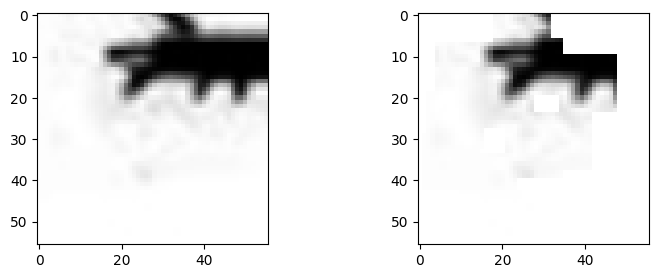

0.0042281374335289
0.0041646407917141914
tensor([0.4733, 0.6606, 0.6185, 0.4300, 0.5236, 0.4783, 0.4405, 0.4522, 0.6363,
        0.6444, 0.3779, 0.3574], device='cuda:7')
tensor([0.3849, 0.6935, 0.6376, 0.3644, 0.4968, 0.4570, 0.5054, 0.3239, 0.6116,
        0.6522, 0.4109, 0.2441])
tensor([0.3893, 0.7049, 0.6508, 0.3685, 0.5042, 0.4642, 0.5034, 0.3186, 0.6272,
        0.6657, 0.4097, 0.2434], device='cuda:7')


In [ ]:
n+=1
model.eval()
o_model.eval()
print(n)
with torch.no_grad():
    in_img = train_tiles[n].reshape(3,56,56).unsqueeze(0).to(DEVICE)
    x, y = model(in_img)
    box, base, pred, l = o_model(x, in_img)

    print(box)
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))

    axes[0].imshow(in_img.reshape(56,56,3).detach().cpu().numpy())
    #axes[0].axis('off')

    axes[1].imshow(base.reshape(56,56,3).detach().cpu().numpy())
    #axes[1].axis('off')
    print(train_cluster[n])
    plt.show()
    print(loss(pred,y).item())
    print(loss(pred,cluster_dists[n].to(DEVICE)).item())
    print(pred[0])
    print(cluster_dists[n])
    print(y[0])

In [602]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_init_d_model1.pickle"
torch.save(model.state_dict(), SAVE_PATH)

SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_init_o_model1.pickle"
torch.save(o_model.state_dict(), SAVE_PATH)

SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_init_d_model1_backup.pickle"
torch.save(model.state_dict(), SAVE_PATH)

SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/whatmatters_init_o_model1_backup.pickle"
torch.save(o_model.state_dict(), SAVE_PATH)

In [488]:
o_model.eval()
with torch.no_grad():
    out = o_model(conv[169].unsqueeze(0))[0]
    print(out)

tensor([0.4961, 0.5171, 0.4878, 0.5181, 0.4893, 0.4994], device='cuda:7')


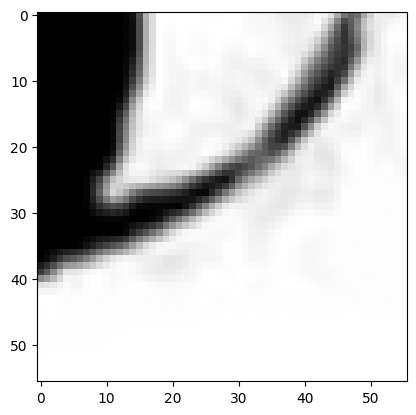

In [490]:
plt.imshow(test_tiles[169].reshape(56,56,3).detach().cpu().numpy())
plt.show()

In [491]:
base = torch.ones(56,56,3)
for o in out.reshape(3,2):
    x_min = int(o[0] * 56)
    y_min = int(o[1] * 56)
    x_max = x_min+14
    y_max = y_min+14
    base[x_min:x_max, y_min:y_max] = test_tiles[169][x_min:x_max, y_min:y_max]


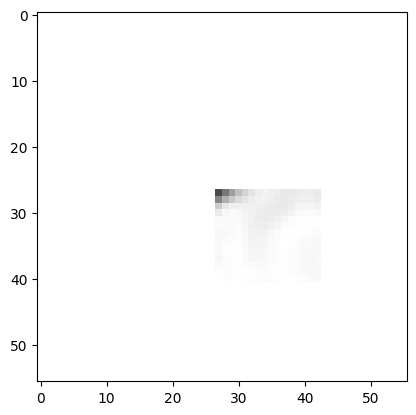

In [492]:
import matplotlib.patches as patches
plt.imshow(base.reshape(56,56,3).detach().cpu().numpy())

plt.show()

Epoch: 0


Train Loss: 2.6185691356658936
Test Loss: 0.013077893294394016

Epoch: 1
Train Loss: 4.466363310813904
Test Loss: 0.08383168280124664

Epoch: 2
Train Loss: 0.9857504367828369
Test Loss: 0.1306329220533371

Epoch: 3
Train Loss: 0.4335505776107311
Test Loss: 0.11838601529598236

Epoch: 4
Train Loss: 0.1894276663661003
Test Loss: 0.17145520448684692

Epoch: 5
Train Loss: 0.11076735612004995
Test Loss: 0.20163533091545105

Epoch: 6
Train Loss: 0.06546270055696368
Test Loss: 0.23045168817043304

Epoch: 7
Train Loss: 0.03978912718594074
Test Loss: 0.25447165966033936

Epoch: 8
Train Loss: 0.030275192810222507
Test Loss: 0.25443536043167114

Epoch: 9
Train Loss: 0.024784686043858528
Test Loss: 0.2580438256263733

Epoch: 10
Train Loss: 0.02040827041491866
Test Loss: 0.25746673345565796

Epoch: 11
Train Loss: 0.023005058988928795
Test Loss: 0.26734060049057007

Epoch: 12
Train Loss: 0.017401195713318884
Test Loss: 0.2632371783256531

Epoch: 13
Train Loss: 0.016578912502154708
Test Loss: 0.26046

In [ ]:
s_model = Discriminator(3, 128, 12)
s_model = s_model.to(DEVICE)
s_optimizer = torch.optim.Adam(s_model.parameters(), lr = LR)
loss = nn.MSELoss()

In [425]:
n=-1

In [426]:
n+=1
model.eval()
with torch.no_grad():
    out = model(train_tiles[n].reshape(3,56,56).to(DEVICE).unsqueeze(0))
    print(out)
    print(out.argmax())
    print(cluster_dists[n])
    print(cluster_dists[n].argmax())
    print(train_cluster[n])

tensor([[0.1761, 0.3635, 0.7116, 0.4861, 0.2940, 0.4402, 0.5499, 0.1935, 0.6286,
         0.5097, 0.4684, 0.3761]], device='cuda:7')
tensor(2, device='cuda:7')
tensor([0.1921, 0.3630, 0.7462, 0.5108, 0.3015, 0.4393, 0.5710, 0.2034, 0.6278,
        0.5121, 0.5224, 0.3982])
tensor(2)
tensor(0.)


In [427]:
n+=1
model.eval()
with torch.no_grad():
    out = model(test_tiles[n].reshape(3,56,56).to(DEVICE).unsqueeze(0))
    print(out)
    print(out.argmax())
    print(te_cluster_dists[n])
    print(te_cluster_dists[n].argmax())
    print(test_cluster[n])

tensor([[0.2593, 0.4116, 0.7252, 0.5696, 0.4040, 0.4303, 0.6239, 0.2999, 0.5534,
         0.5677, 0.5029, 0.3411]], device='cuda:7')
tensor(2, device='cuda:7')
tensor([0.2681, 0.4193, 0.7577, 0.5917, 0.4077, 0.4306, 0.6630, 0.3285, 0.6058,
        0.5836, 0.5645, 0.3457])
tensor(2)
tensor(0.)


In [16]:
print(train_tiles[tr_ind].shape)
print(train_cluster[tr_ind].shape)

torch.Size([100, 56, 56, 3])
torch.Size([100])


In [18]:
train_cluster[tr_ind]

tensor([ 0,  8,  4,  3,  1,  0,  2, 11,  2,  7,  1, 11,  5,  5, 11,  7, 10,  1,
         0,  5,  9, 10,  2,  6,  2,  2,  3,  8, 11, 10,  1,  2,  3,  0,  2,  0,
         2,  9,  2, 11, 10,  0,  1,  1,  2,  0,  2, 10,  0, 11,  2,  2, 10, 11,
        10,  1,  0,  9,  9,  7,  8,  3,  9,  8,  9,  6,  3,  1,  4,  5, 11, 11,
        11,  4,  2,  1,  1, 11, 10, 11,  0,  6,  1,  5,  4, 11,  5,  6,  2,  2,
         0,  0,  1,  7,  1, 11,  2,  1, 11,  1], dtype=torch.int32)